# Analyzing Game Success for Ice online store

I will analyze user and expert reviews, genres, platforms, and historical data on game sales that are available from open sources. I will identify patterns that determine whether a game succeeds or not. I will be forecasting 2017 sales based on data from 2016.

In [1]:
!pip install --upgrade seaborn

In [2]:
pip install sidetable

Note: you may need to restart the kernel to use updated packages.


## General Information

In [3]:
import pandas as pd
import numpy as np
import sidetable
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [4]:
try:
    games = pd.read_csv('games.csv')
except:
    games = pd.read_csv('/datasets/games.csv')

In [5]:
games.sample(1)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
14573,Daibakushou: Jinsei Gekijou,SNES,1995.0,Misc,0.0,0.0,0.03,0.0,NaN,NaN,NaN


In [6]:
games.duplicated().sum()

0

## Preparing the Data

I will convert column names to lower case

In [7]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [8]:
games.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

○ wrong data types in columns: `User_Score` (object not float), `Year_of_Release` (float not integer)

In [9]:
games.stb.missing(style=True)

,missing,total,percent
critic_score,"8,578","16,715",51.32%
rating,"6,766","16,715",40.48%
user_score,"6,701","16,715",40.09%
year_of_release,269,"16,715",1.61%
name,2,"16,715",0.01%
genre,2,"16,715",0.01%
platform,0,"16,715",0.00%
na_sales,0,"16,715",0.00%
eu_sales,0,"16,715",0.00%
jp_sales,0,"16,715",0.00%


#### name and genre

In [10]:
games[games.name.isna() & games.genre.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


I will fill these missing values with a string value

In [11]:
games.name.fillna('unknown', inplace=True)
games.genre.fillna('unknown', inplace=True)
len(games[games.name.isna() & games.genre.isna()])

0

#### year_of_release

I will try to fill missing values for year of release by creating a dictionary of year by game.

In [12]:
game_year = dict(zip(games.name, games.year_of_release))

games.year_of_release = games.year_of_release.fillna(games.name.map(game_year))

games.year_of_release.isna().sum()

204

I will fill the rest of the missing values with 0 and turn the data type to int

In [13]:
games.year_of_release = games.year_of_release.fillna(0).astype(int)

games.year_of_release.isna().sum()

0

#### rating

I will try to fill the missing values in rating with a dictionary of rating per game and the rest I will fill with a string

In [14]:
game_rating = dict(zip(games.name, games.rating))

games.rating = games.rating.fillna(games.name.map(game_rating))

games.rating.isna().sum()

6567

#### user_score

In [15]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

I will convert data in `user_score` column by first removing the string value 'tbd' (to be determind)

First, I will check if there is a coorolation between 'tbd' and year of release or platform

In [16]:
games[games.user_score=='tbd']['year_of_release'].value_counts()

2009    405
2010    332
2008    327
2011    217
2007    193
2002    193
2006    125
2005    122
2004    107
2003     96
2001     82
2000     43
0        38
2015     38
2016     34
2012     26
2014     21
2013     15
1999      8
1997      2
Name: year_of_release, dtype: int64

In [17]:
games.loc[games['user_score'] == 'tbd', 'platform'].nunique()

16

There is no coralation so I will remove the 'tbd' values

In [18]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = float('nan')
games['user_score'] = games['user_score'].astype(float)
games['user_score'].isna().sum()

9125

In [19]:
games[games.user_score.isna()].describe(include='object')

,name,platform,genre,rating
count,9125,9125,9125,2631
unique,7633,31,13,6
top,FIFA 12,DS,Action,E
freq,7,1635,1539,1687


I will not fill missing values for `user_score` because this parameter can not be extrapolated from this dataset. 

#### critic_score

In [20]:
games[games.critic_score.isna()].describe(include='object')

,name,platform,genre,rating
count,8578,8578,8578,2082
unique,7123,31,13,6
top,The Amazing Spider-Man 2 (2014),DS,Action,E
freq,7,1434,1479,1252


I will not fill missing values for `critic_score` because this parameter can not be extrapolated from this dataset. 

### Total sales

In [21]:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
games.sample()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
13297,American Bass Challenge,GBA,2001,Sports,0.03,0.01,0.0,0.0,69.0,NaN,E,0.04


## Analyzing Data

### Data per Year

In [22]:
years_nozero = games[games.year_of_release != 0]
years_nozero.stb.freq(['year_of_release'],style=True, cum_cols=True)

,year_of_release,count,percent,cumulative_count,cumulative_percent
0,2008,"1,432",8.67%,"1,432",8.67%
1,2009,"1,428",8.65%,"2,860",17.32%
2,2010,"1,263",7.65%,"4,123",24.97%
3,2007,"1,201",7.27%,"5,324",32.25%
4,2011,"1,143",6.92%,"6,467",39.17%
5,2006,"1,014",6.14%,"7,481",45.31%
6,2005,944,5.72%,"8,425",51.03%
7,2002,839,5.08%,"9,264",56.11%
8,2003,780,4.72%,"10,044",60.83%
9,2004,764,4.63%,"10,808",65.46%


The amount of games released per year varies. 50% of the games were released between 2005 to 2011. 97% of the games were released after 1995.

<AxesSubplot:xlabel='year_of_release'>

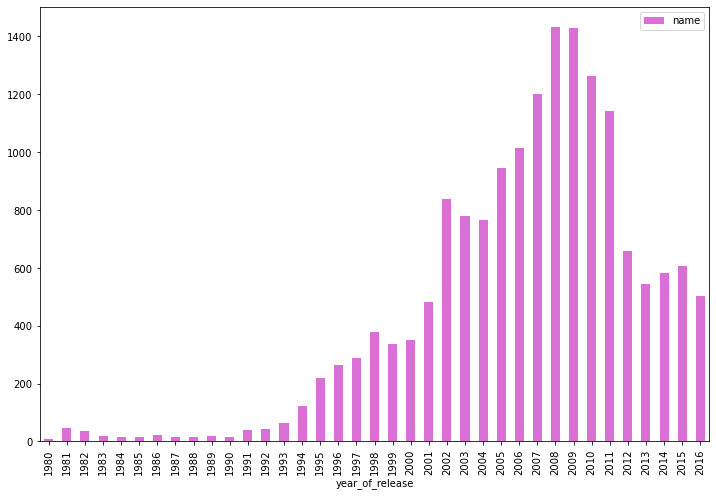

In [23]:
years_nozero.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar', color='orchid', figsize=(12,8))

The number of games released per year increases per year until 2008/9 and then decreases until 2016.

### Sales per Platform

<AxesSubplot:xlabel='age', ylabel='Count'>

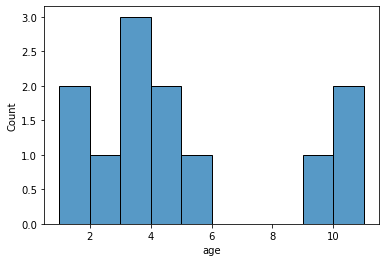

In [24]:
platform_age = games.groupby('platform')['year_of_release'].agg(['min','max'])
platform_age.where(platform_age['min'] != 0, platform_age['max'], inplace=True, axis=0)
platform_age['age'] = platform_age['max'] - platform_age['min']
sns.histplot(platform_age.query('age > 0')['age'], bins=10)

Most platforms have a lifespan of around 3 years. The platforms that really succeed have just over 10 years lifespan.

In [25]:
games.stb.freq(['platform'],style=True, cum_cols=False)

,platform,count,percent
0,PS2,"2,161",12.93%
1,DS,"2,151",12.87%
2,PS3,"1,331",7.96%
3,Wii,"1,320",7.90%
4,X360,"1,262",7.55%
5,PSP,"1,209",7.23%
6,PS,"1,197",7.16%
7,PC,974,5.83%
8,XB,824,4.93%
9,GBA,822,4.92%


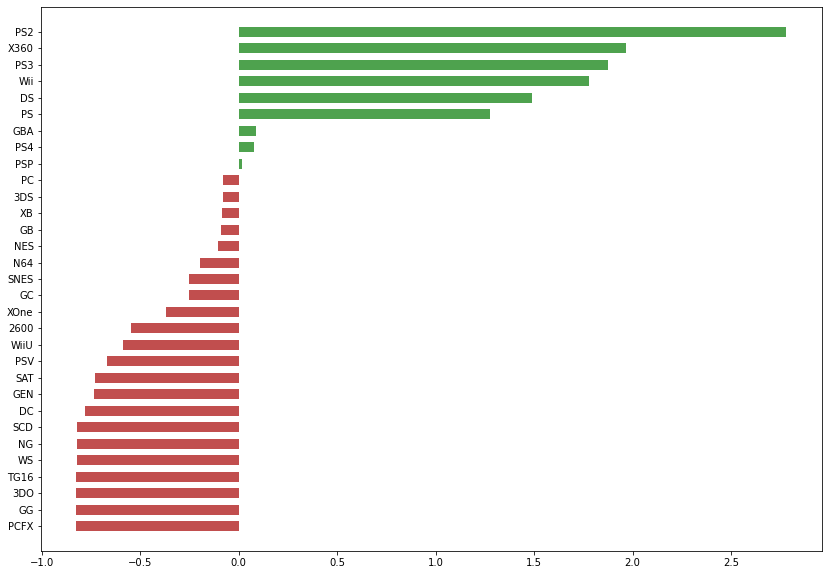

In [26]:
platform_sales = games[['platform','total_sales']].groupby('platform').sum().sort_values(by='total_sales').reset_index()
platform_sales['standard_score'] = (platform_sales['total_sales']-platform_sales['total_sales'].mean())/platform_sales['total_sales'].std()
platform_sales['color'] = ['firebrick' if x<0 else 'forestgreen' for x in platform_sales['standard_score']]
plt.figure(figsize=(14,10))
plt.hlines(y=platform_sales.platform,xmax=platform_sales.standard_score, xmin=0,color=platform_sales.color, alpha=0.8, linewidth=10)

The platforms with the most games are also the platforms with the highest total sales.

I will build a distribution of yearly data for the platforms with positive standard score.

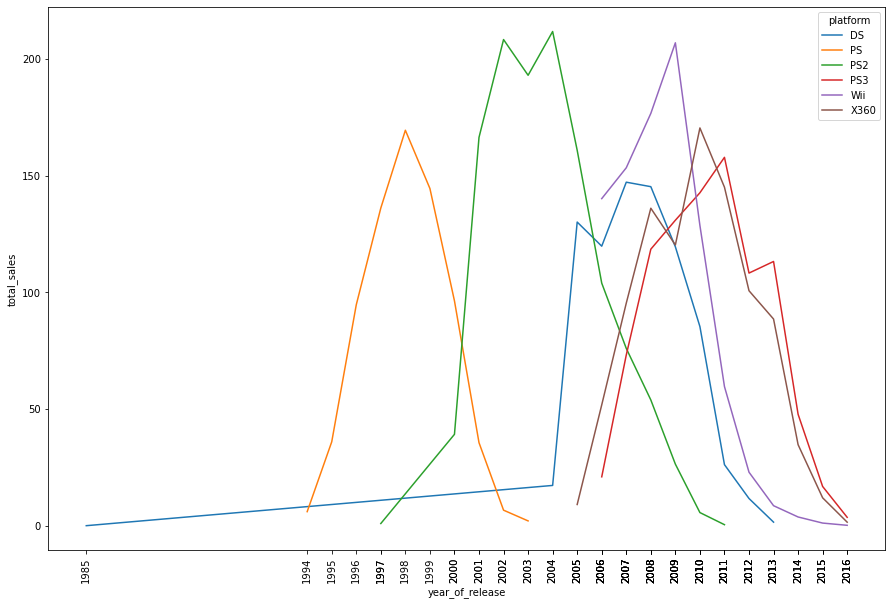

In [27]:
filtered = years_nozero[years_nozero['platform'].isin(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'])].groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=filtered, x='year_of_release', y='total_sales',hue='platform')
ax.set_xticks(filtered.year_of_release)
ax.set_xticklabels(filtered.year_of_release,rotation=90)
plt.show()

The platforms with the highest total sales have zero sales by 2016 (or earlier). This is reasonable because they have already accumulated all the revenue they ever will.
The average lifetime of a top preforming platform is approximatly 12 years, and the average time it takes a platform to reach maximun sales is approximatly 4 years (which is also just over the average lifespan of the less successful platforms).

I will look for a platform that has the highest total sales and is still active in 2016. To do that I will review data from 2012 onward for platforms of medium standard score.

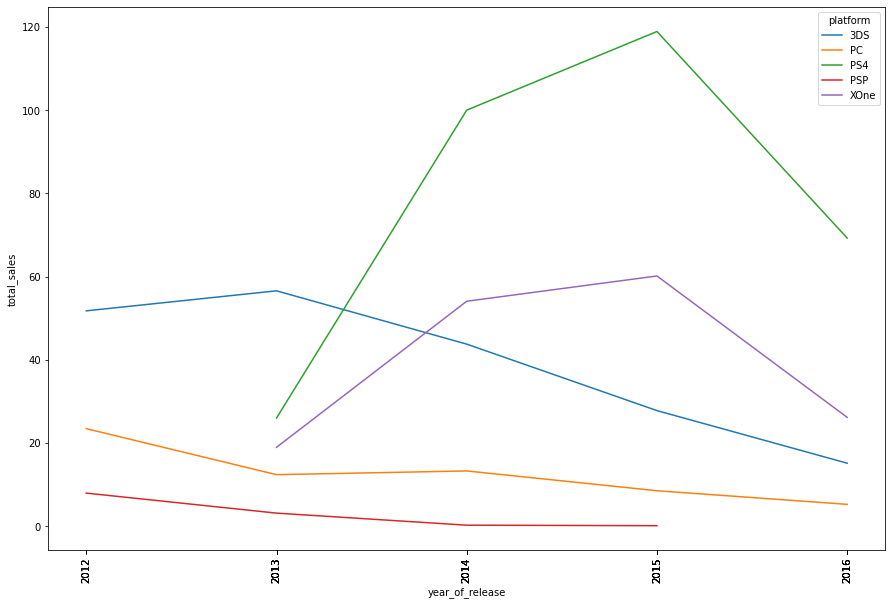

In [28]:
filtered = years_nozero[years_nozero['platform'].isin(['GBA', 'PS4', 'PSP', 'PC', '3DS', 'XB', 'GB', 'NES', 'N64', 'SNES', 'GC', 'XOne'])].query('year_of_release >= 2012').groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=filtered, x='year_of_release', y='total_sales',hue='platform')
ax.set_xticks(filtered.year_of_release)
ax.set_xticklabels(filtered.year_of_release,rotation=90)
plt.show()

In order to make a more accurate prediction for 2017., I will pick the platform PS4 for the rest of the analysis becauses it has the highest total sales from the platforms that are still active in 2016. In addition PS, PS2, and PS3 are all on the highest total sales list. Combined with the fact that the data for 2016 maybe incomplete, I can assume that PS4 will generate more sales in the years to come.

In [29]:
data_new = years_nozero.query('year_of_release >= 2012')

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

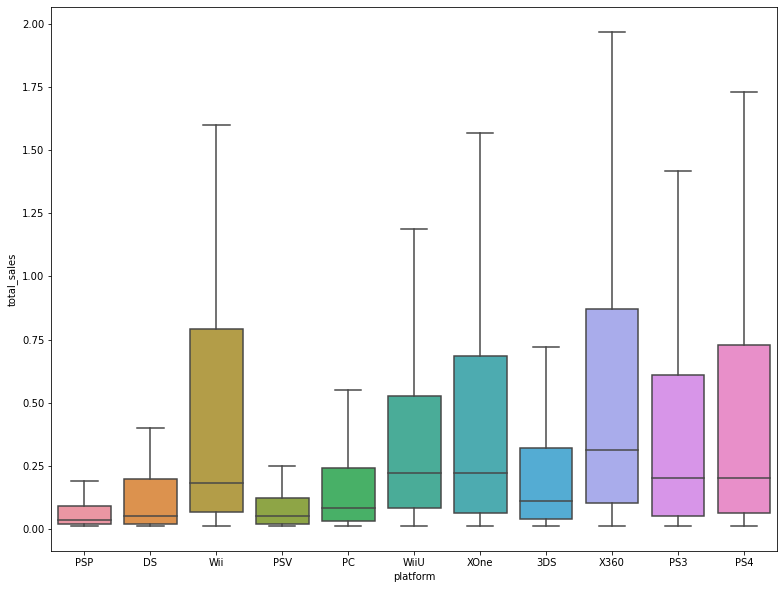

In [30]:
grouped=data_new.groupby(['platform','name'])['total_sales'].sum().reset_index()
order=grouped.groupby('platform')['total_sales'].sum().reset_index().sort_values(by='total_sales')['platform']

plt.figure(figsize=(13,10))
sns.boxplot(x='platform',y='total_sales',data=grouped, order=order, showfliers = False)

The median sales on variouse platforms dosn't shift very much, but the distribution of the total sales is different, platforms with bigger total sales are more skewed to the right- they have more games with higher sales.

From this graph I am certian that PS4 is the right platform to go forward with because it has a similar distribution of sales like other top platforms, even though it has less games. 


### Reviews Effect on Sales

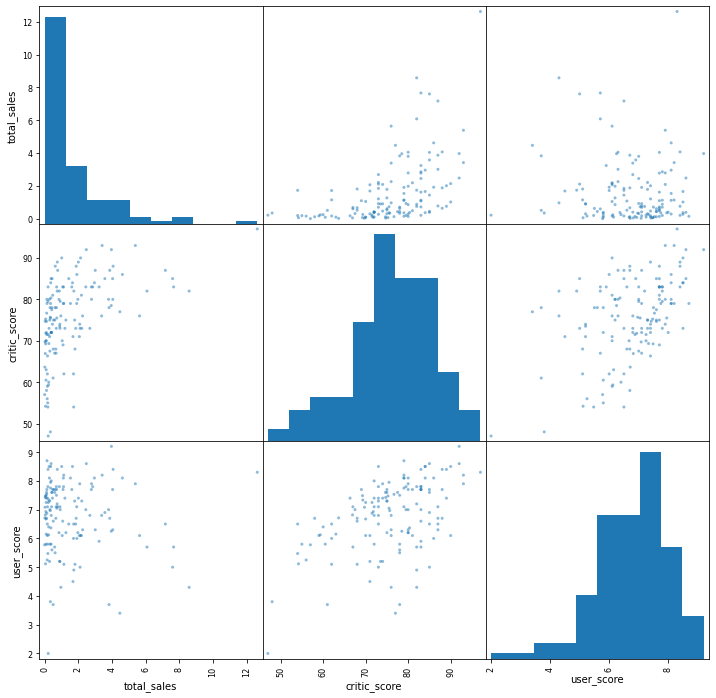

In [31]:
data_new_ps4 = data_new.query('platform == "PS4"')
review_analysis_ps4 = data_new_ps4.pivot_table(index='total_sales', values=['critic_score', 'user_score'])
pd.plotting.scatter_matrix(review_analysis_ps4.reset_index(), figsize=(12,12))
plt.show()

In [32]:
data_new_ps4.corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.248961,-0.208306,-0.060993,-0.234796,-0.021142,0.152447,-0.235032
na_sales,-0.248961,1.000000,0.785362,0.472981,0.944259,0.415008,-0.020933,0.928160
eu_sales,-0.208306,0.785362,1.000000,0.464563,0.944698,0.346720,-0.048925,0.958157
jp_sales,-0.060993,0.472981,0.464563,1.000000,0.496467,0.322358,0.171332,0.527129
other_sales,-0.234796,0.944259,0.944698,0.496467,1.000000,0.409191,-0.035639,0.998051
critic_score,-0.021142,0.415008,0.346720,0.322358,0.409191,1.000000,0.557654,0.406568
user_score,0.152447,-0.020933,-0.048925,0.171332,-0.035639,0.557654,1.000000,-0.031957
total_sales,-0.235032,0.928160,0.958157,0.527129,0.998051,0.406568,-0.031957,1.000000


There is a medium high positive corolation between critic score and user score (0.56), the scatter plot also shows a slight liniar tendency between the two scores.

There is a medium low positive corrolation between critic score and sales (NA 0.42, EU 0.35, JP 0.32,  Other 0.41, Total 0.4), games tend to sell better when they have a high critic score.

There is a very small corrolation between user score with diffrent tendencies by region (NA -0.02, EU -0.05, JP 0.17, Other -0.03, Total -0.03).

The scatter plot shows that critic score is distributed randomly for the low total sales but for the high total sales the critic scores are also high. The scatter plot shows user score has a random distributii. for total sales.

I am concluding thatcritic score has an effecton sales, and user score dosen't have an effect on sales excpet for slightly in japan.

In [33]:
def reviews_effect(platform):
    df=data_new[(data_new['name'].isin(data_new_ps4['name']))&(data_new['platform'] == platform)][['total_sales', 'critic_score', 'user_score']]
    sns.scatterplot(x='total_sales', y='critic_score', data=df, color='turquoise')
    plt.show()
    sns.scatterplot(x='total_sales', y='user_score', data=df, color='aquamarine')
    plt.show()
    display(df.corr())   

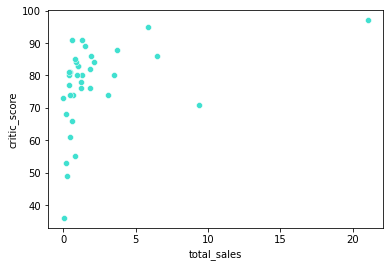

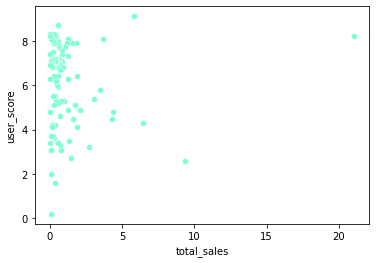

,total_sales,critic_score,user_score
total_sales,1.000000,0.374673,0.010655
critic_score,0.374673,1.000000,0.532986
user_score,0.010655,0.532986,1.000000


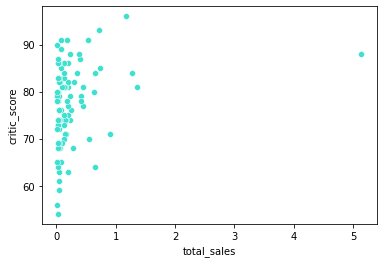

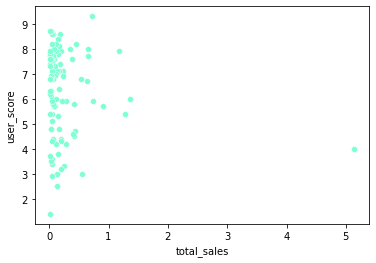

,total_sales,critic_score,user_score
total_sales,1.000000,0.246682,-0.101728
critic_score,0.246682,1.000000,0.412867
user_score,-0.101728,0.412867,1.000000


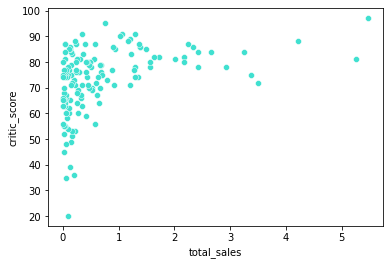

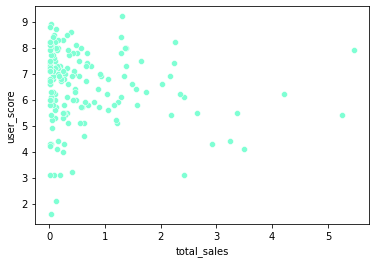

,total_sales,critic_score,user_score
total_sales,1.000000,0.401749,-0.110897
critic_score,0.401749,1.000000,0.442985
user_score,-0.110897,0.442985,1.000000


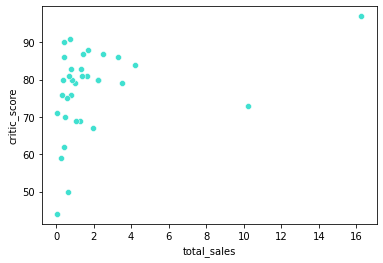

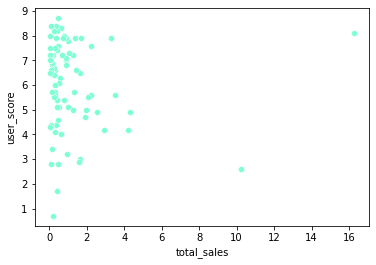

,total_sales,critic_score,user_score
total_sales,1.000000,0.340898,-0.055321
critic_score,0.340898,1.000000,0.392444
user_score,-0.055321,0.392444,1.000000


In [34]:
reviews_effect('PS3')
reviews_effect('PC')
reviews_effect('XOne')
reviews_effect('X360')

There is a slight diffrence between the corrolation on diffrent platform but it's not statistacly significant. We can attribute these variation to diffrent popularity of platforms in the diffrent regions, and diffrent popularity of the games on the diffrent platforms.

### Sales by Genre

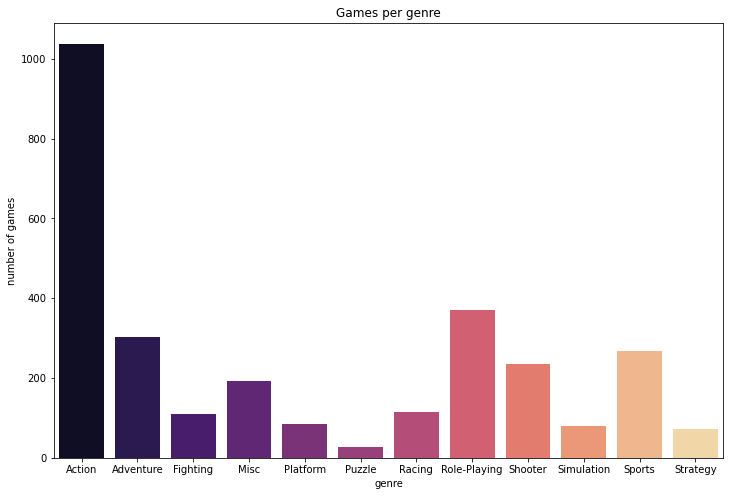

In [35]:
grouped=data_new.groupby('genre')['name'].count().reset_index()
plt.figure(figsize=(12,8))
ax = sns.barplot(x='genre',y='name',data=grouped, palette='magma')
ax.set(ylabel='number of games')
ax.set_title('Games per genre')
plt.show()

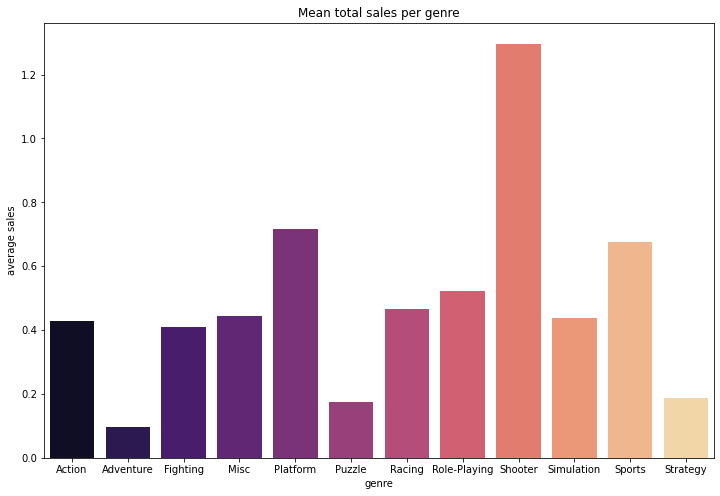

In [36]:
grouped=data_new.groupby('genre')['total_sales'].mean().reset_index()
plt.figure(figsize=(12,8))
ax = sns.barplot(x='genre',y='total_sales',data=grouped, palette='magma')
ax.set(ylabel='average sales')
ax.set_title('Mean total sales per genre')
plt.show()

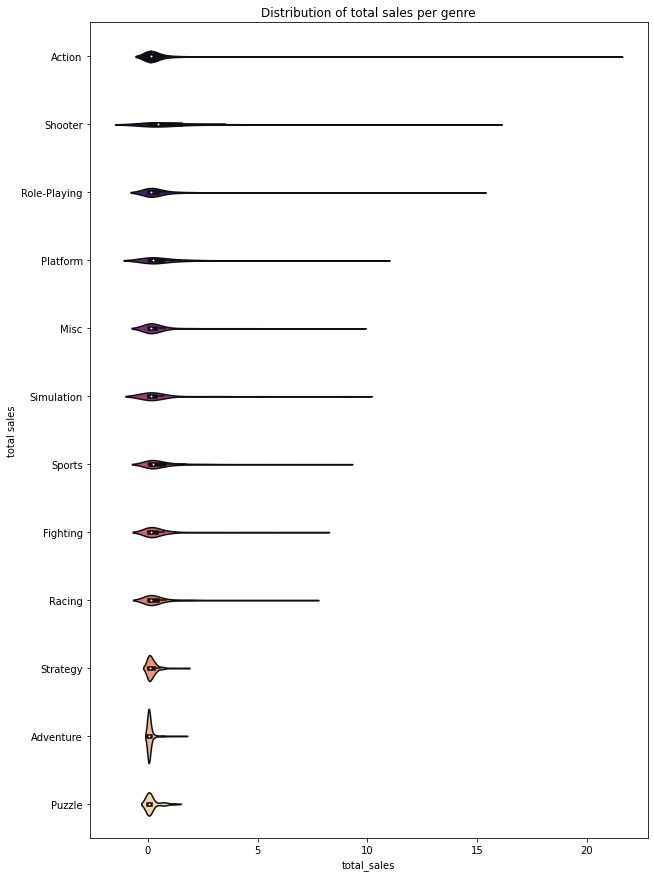

In [37]:
plt.figure(figsize=(10,15))
ax = sns.violinplot(x='total_sales',y='genre',data=data_new, palette='magma')
ax.set(ylabel='total sales')
ax.set_title('Distribution of total sales per genre')
plt.show()

There are more Action games then any other genre, thus the sum of total sales are the highest. Shooter games genrate more sales on average then any other genre, thus they have the second highest sum of total sales.

From the mean total sales per genre we can see that genres that require more equipment- Shooter and Sports , cost more and thus have a higher average sale which lead to highe total sales. Action and Role Playing have medium average sale but they are more popular genres which leads to high total sales.

## User Profile per Region

### Top 5 platforms per region

In [38]:
def platform_sales(region):
    grouped=data_new.groupby('platform')[f'{region}_sales'].sum().reset_index()
    order=grouped.groupby('platform')[f'{region}_sales'].sum().reset_index().sort_values(by=f'{region}_sales')['platform']
    plt.figure(figsize=(12,8))
    ax = sns.barplot(x='platform',y=f'{region}_sales' ,data=grouped, order=order, palette='deep')
    ax.set_title(f'Sum of {region.upper()} Sales per Platform')
    plt.show()

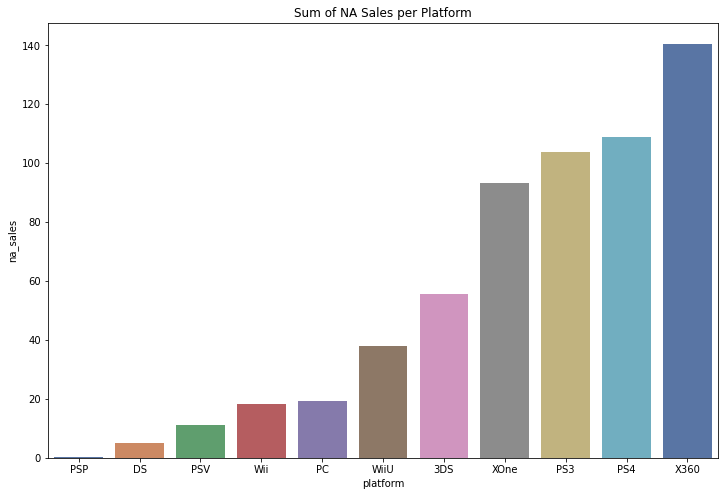

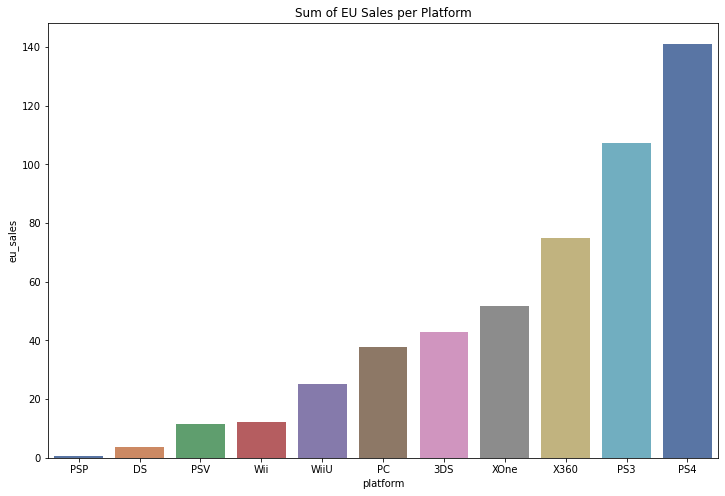

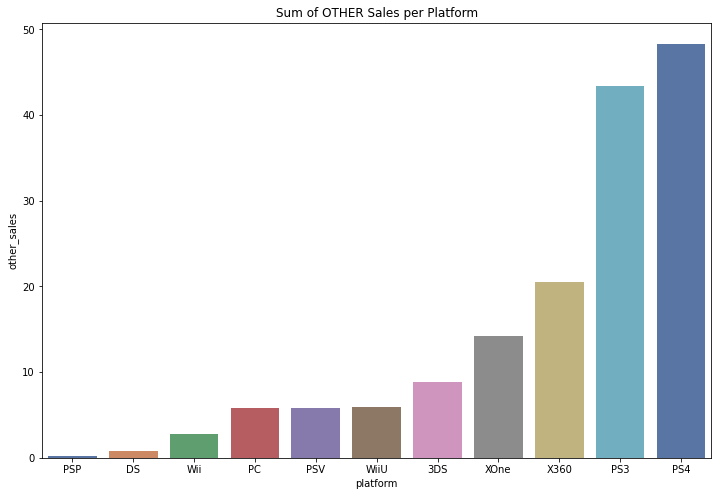

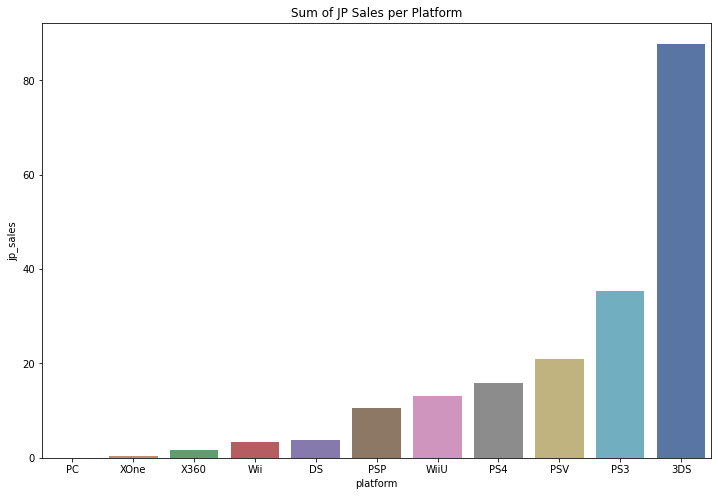

In [39]:
platform_sales('na')
platform_sales('eu')
platform_sales('other')
platform_sales('jp')

North America, Europe, and Other regions have the same 5 genres with the most sales- PS4, PS3, X360, XOne, 3DS, (the order of them is the same in europe and other, while in north america X360 moves to first). 
The 5 platforms with the most sales in Japan are diffrent- 3DS, PS3, PSV, PS4, WiiU.

In [40]:
def genre_sales(region):
    grouped=data_new.groupby('genre')[f'{region}_sales'].sum().reset_index()
    order=grouped.groupby('genre')[f'{region}_sales'].sum().reset_index().sort_values(by=f'{region}_sales')['genre']
    plt.figure(figsize=(12,8))
    ax = sns.barplot(x='genre',y=f'{region}_sales' ,data=grouped, order=order, palette='colorblind')
    ax.set_title(f'Sum of {region.upper()} Sales per Genre')
    plt.show()

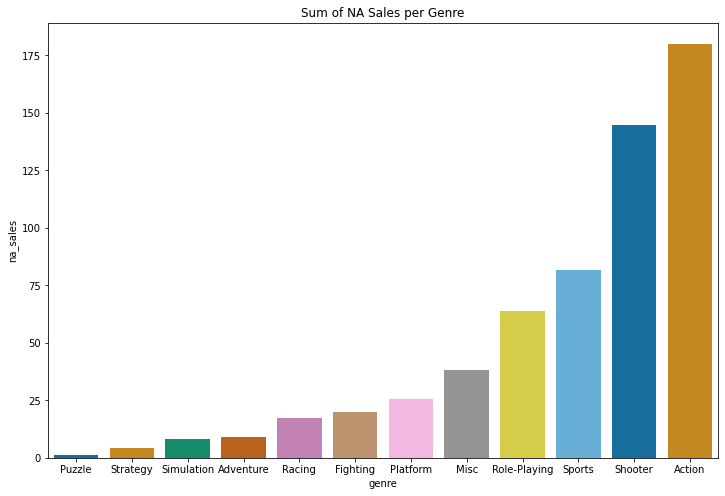

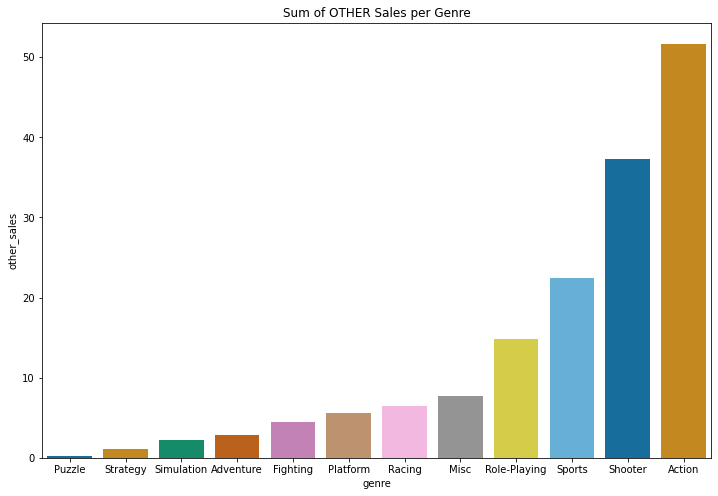

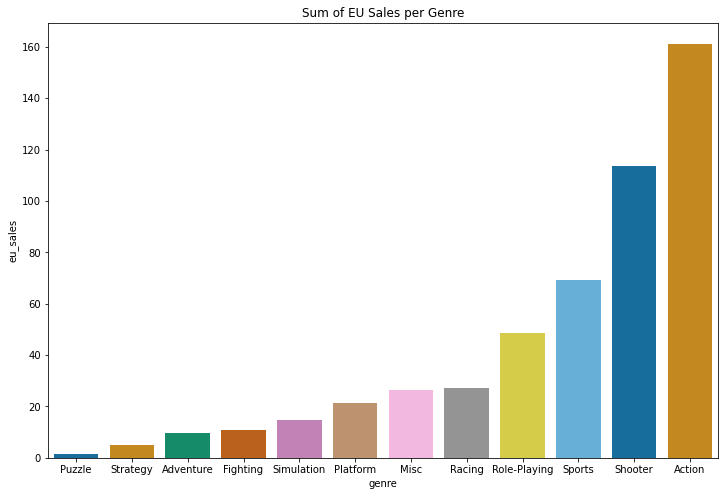

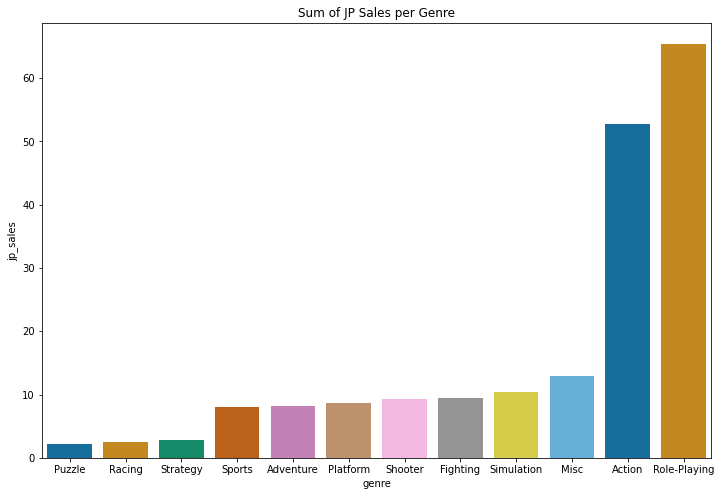

In [41]:
genre_sales('na')
genre_sales('other')
genre_sales('eu')
genre_sales('jp')

North America, Europe, and Other regions have the same 4 genres with the most sales- Action, Shooter, Sports, Role Playing, while the fifth genre is the same for north america and other- Misc, and diffrent in europe- Racing (the 6th top game in other is racing and in europe misc). 
The 5 genres with the most sales in Japan are diffrent- Role Playing, Action, Misc, Simulation, and Fighting.

The diffrence is probably due to cultural and economic resons, Japan has a strong gaming and animation cultural, in addition to the fact japan also makes many videoe games, an economic bubble has evovlved due to marketing strategies and private development. 

In [42]:
def rating_sales(region):
    grouped=data_new.groupby('rating')[f'{region}_sales'].sum().reset_index()
    order=grouped.groupby('rating')[f'{region}_sales'].sum().reset_index().sort_values(by=f'{region}_sales')['rating']
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x='rating',y=f'{region}_sales' ,data=grouped, order=order, palette='muted')
    ax.set_title(f'Sum of {region.upper()} Sales per Rating')
    plt.show()

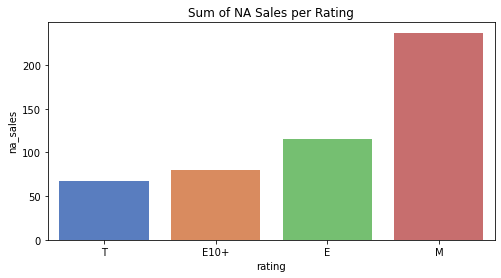

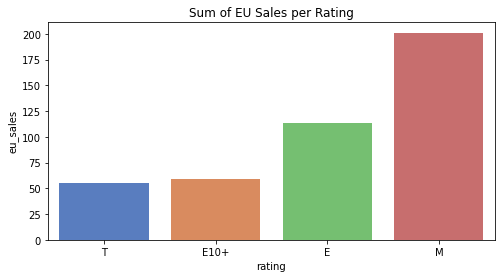

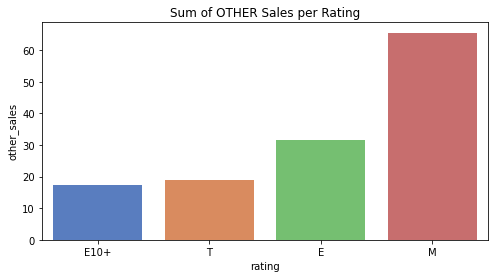

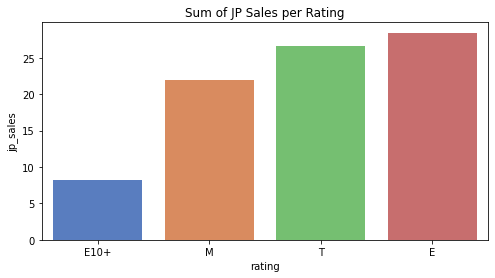

In [43]:
rating_sales('na')
rating_sales('eu')
rating_sales('other')
rating_sales('jp')

Regions North America and Europe preffer games that are targeted to adults, while in Japan there is a preffrence to games that are more targeted twoards teens. 

## Testing Hypotheses

Ttsest checks if there is a significant diffrence between mmeans of two populations, so I will set the null hypothesis as the means are the same. I used a standard alpha because there is a small chance of type 1 error.

**H0: Average user ratings of the Xbox One and PC platforms are the same**

**H1: Average user ratings of the Xbox One and PC platforms are diffrent**

In [44]:
data_new_pc = data_new[data_new['user_score'].notna()].query('platform == "PC"')
data_new_xb1 = data_new[data_new['user_score'].notna()].query('platform == "XOne"')
alpha = 0.05

st.levene(data_new_pc['user_score'], data_new_xb1['user_score'], center='mean')

LeveneResult(statistic=8.744880016557625, pvalue=0.003295124795068392)

pvalues of levene test is smaller then alpha so I will take the variances as not equal

In [45]:
result = st.ttest_ind(data_new_pc['user_score'], data_new_xb1['user_score'], equal_var=False)
print('Pvalue:', result.pvalue)
if result.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We can`t reject the null hypothesis')
print()
#general means
print('PC mean:', data_new_pc['user_score'].mean()) 
print('Xbox One mean:', data_new_xb1['user_score'].mean())

Pvalue: 0.5926118514134824
We can`t reject the null hypothesis

PC mean: 6.438647342995167
Xbox One mean: 6.52142857142857


**H0: Average user ratings for the Action and Sports genres are the same**

**H1: Average user ratings for the Action and Sports genres are different**

In [46]:
data_new_action = data_new[data_new['user_score'].notna()].query('genre == "Action"')
data_new_sports = data_new[data_new['user_score'].notna()].query('genre == "Sports"')
alpha = 0.05

st.levene(data_new_action['user_score'], data_new_sports['user_score'], center='mean')

LeveneResult(statistic=21.540633719264733, pvalue=4.115147269912941e-06)

pvalues of levene test is smaller then alpha so I will take the variances as not equal

In [47]:
result = st.ttest_ind(data_new_action['user_score'], data_new_sports['user_score'], equal_var=False)
print('Pvalue:', result.pvalue)
if result.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We can`t reject the null hypothesis')
print()
#general means
print('Action mean:', data_new_action['user_score'].mean()) 
print('Sports mean:', data_new_sports['user_score'].mean())

Pvalue: 2.4230859247730916e-20
We reject the null hypothesis

Action mean: 6.8342803030303125
Sports mean: 5.455897435897437


## General Conclusion

○ Data collection should check updating 'tbd' values in user_score.

○ Most of the games were released between 5 to 15 years ago.

○ Successfull platforms tend to reach thier overall peak sales after approximatley 4 years, if the platform hasn't reached high enough sales after this period it will die off. The lifetime of a successfull platform is between approximatley 10 years. 
Successfull platforms tend to have games with high total sales.

○ Scores of critics have a medium low influence on sales, while user score dosent have an influence except for in Japan where user score has a small influence. In general games that have high total sales have a high critic score. Except for in Japan user score is not an indicator of game success.  
Critic score has a medium high corralation with user score, users tend to agree with critics but not all the time.

○ In North America, Europe, and other regions genres with high sales are physical, imersive ,and dynamic. The genres with low sales are monotonous, and require thinking and skills that take time to develope. In Japan high selling games tend to be very immersive and self expressive.

○ There is a diffrence in popularity of platforms between Japan and the rest of the regions, while Europe amd Other have similar platform popularity and North America is also similar but has a diffrent number one.

○ Ratings of games in the diffrent regions is an extension of the diffrences of genres popularity.

○ Average game user rating dosen't seem to be effected by the platform type, but it seems to be effected by genre.